# Permutation Importance

[Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
len(feature_names)

18

In [2]:
data = pd.read_csv("data/FIFA 2018 Statistics.csv")

y = (data['Man of the Match'] == "Yes")
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

In [29]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(X_test, y_test)

In [30]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using `accuracy` as the performance metric, since it is the default metric used in the `score` method of `RandomForestClassifier`).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **Goals Scored**. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

# Partial Dependence Plots

In [32]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_train, y_train)

In [60]:
data['Man of the Match'].value_counts()

Yes    64
No     64
Name: Man of the Match, dtype: int64

In [56]:
tree_model.classes_

array([False,  True])

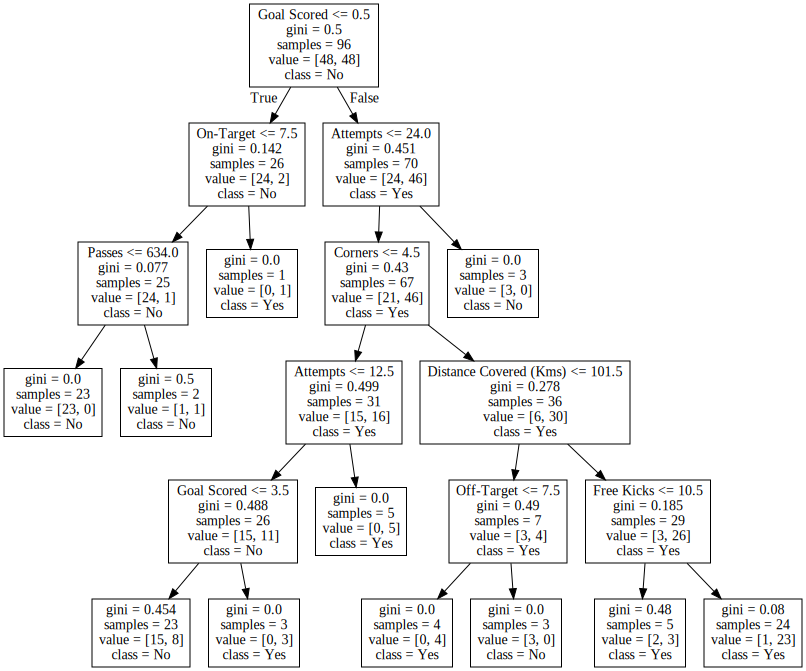

In [58]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names, class_names=["No", "Yes"])
graphviz.Source(tree_graph)

Creating the Partial Dependence Plot

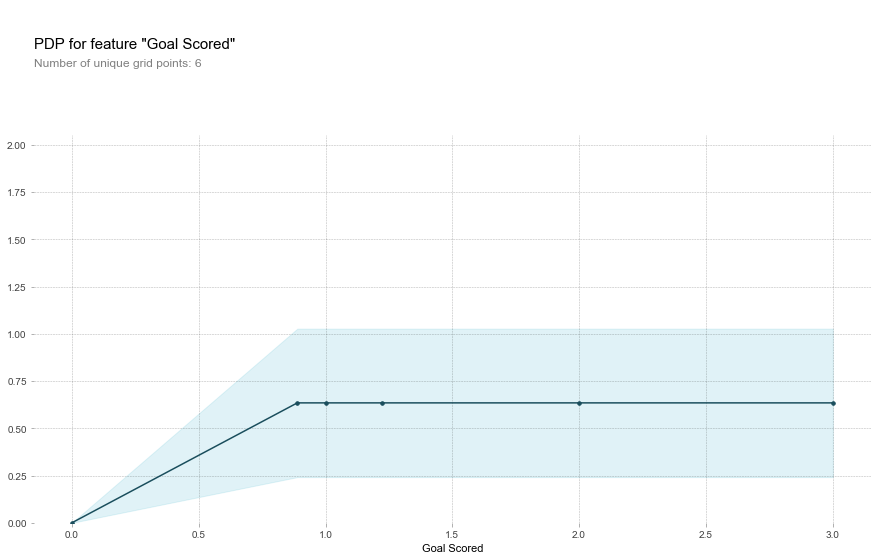

In [76]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature="Goal Scored")

pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

A few items are worth pointing out as you interpret this plot

* The y axis is interpreted as **change in the prediction** from what it would be predicted at the **baseline** or **leftmost value**.
* A blue shaded area indicates level of confidence.

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match". But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

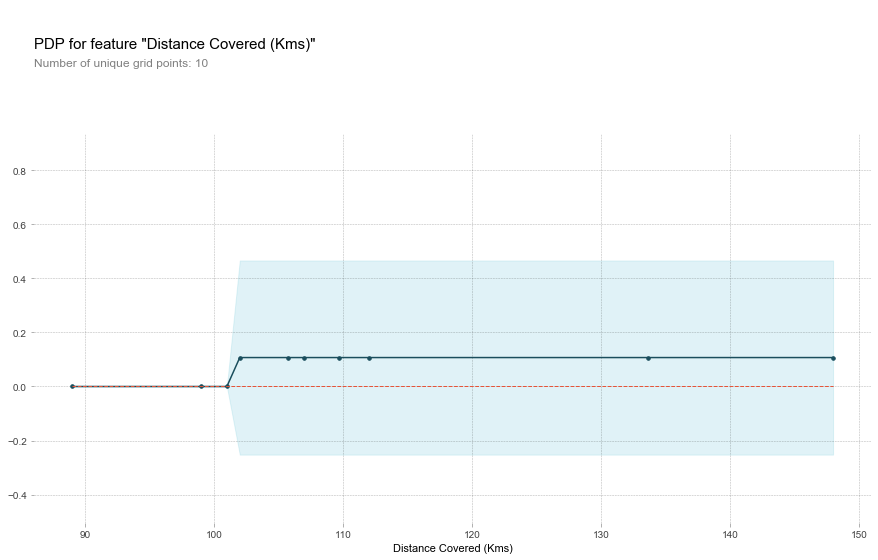

In [77]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

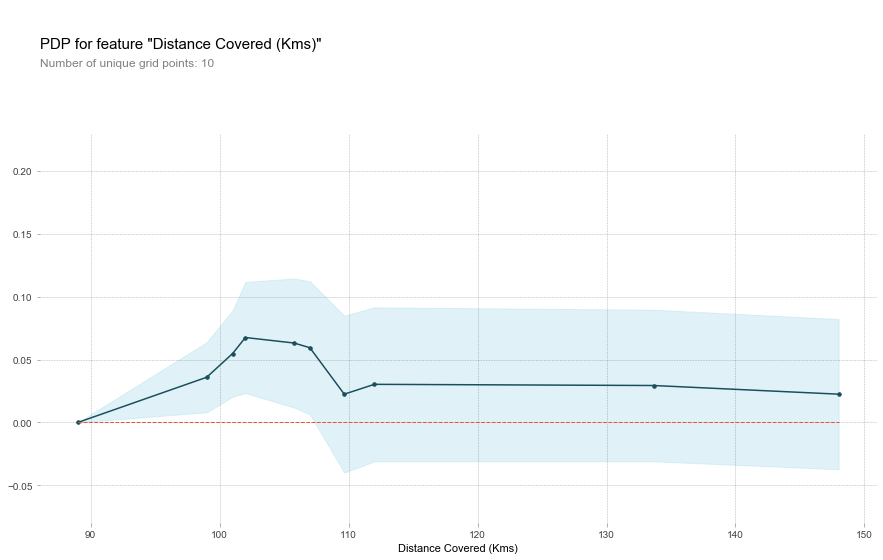

In [78]:
# Build Random Forest Model
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win *Man of the Match* if your players run a total of ~ 100km or a little more over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model. Though this dataset is small enough that we would be careful in how we interpret any model.

Let's do the same with the `Goals Scored` variable using the more sophisticated `RandomForestClassifier` model.

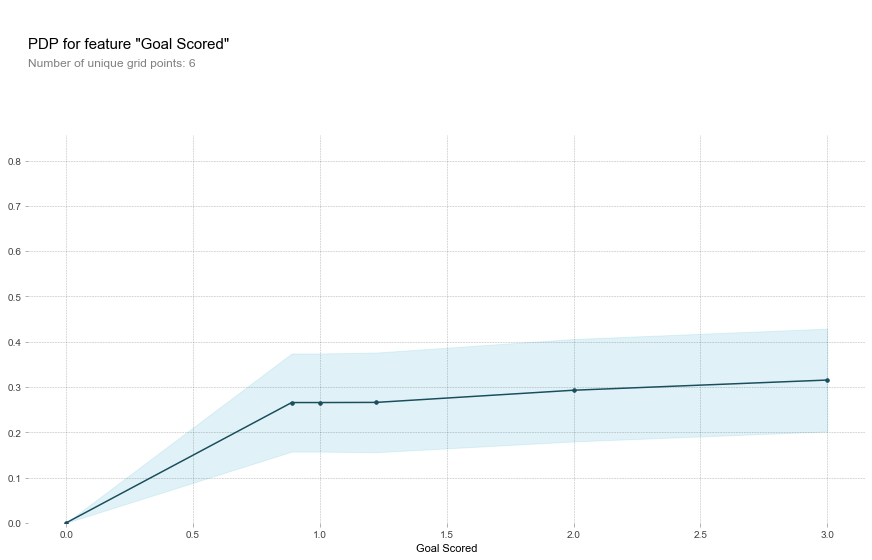

In [79]:
feature_to_plot = "Goal Scored"
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

The Random Forest model was able to capture a more realistic scenario. It believes that the chances of winning the *Man of the Match* increases with the number of goals scored.